# Soft Actor-Critic
### Implementation using Equinox

Temporal file (backup)

In [1]:
import jax.numpy as jnp
import jax.random as jrandom

import jax

from src.systems.linear import StochasticDoubleIntegrator
from src.RL.PolicyGradient.SoftActorCritic.main import *

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
seed = 0
T = 10

key = jrandom.PRNGKey(seed)

x0 = jnp.array([2, 0])
SDI = StochasticDoubleIntegrator(x0, boundary=5)

dim_q = (3, 32, 1)
dim_v = (2, 32, 1)
dim_pi = (2, 1)

SAC = SoftActorCritic(dim_q, dim_v, dim_pi, key)
key0, key1, key2, key = jrandom.split(key, 4)

time_horizon = jnp.arange(0, T, SDI.dt)
for t in time_horizon:
    s0_estimate = SDI.observe(key0)
    control, _ = SAC.get_control(s0_estimate)
    _, cost, done = SDI.update(key1, control, info=True)
    s1_estimate = SDI.observe(key2)

    SAC.update((s0_estimate, control, -cost, s1_estimate), key)

    # step
    key0, key1, key2, key = jrandom.split(key, 4)

    if done:
        x0 = jrandom.normal(key, (2,))*2
        SDI.reset(x0)



In [8]:
np.max(SAC.certainty)

7.531332380835624

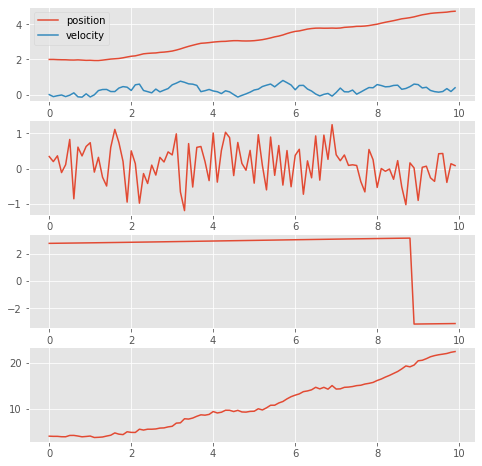

In [4]:
TH = time_horizon
TK = SAC.tracker.memory


labels = {'y':[None, 'control', 'angle', 'cost']}
fig, ax = plt.subplots(4, figsize=(8, 8))
ax[0].plot(TH, TK['state0'], label='position')
ax[0].plot(TH, TK['state1'], label='velocity')
ax[0].legend()
ax[1].plot(TH, TK['control'])
ax[2].plot(TH, TK['policy_angle'])
ax[3].plot(TH, TK['cost'])


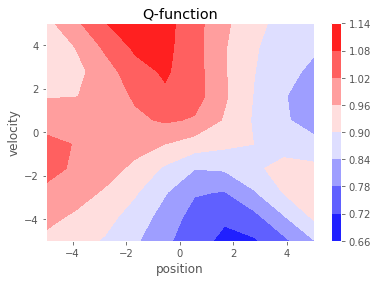

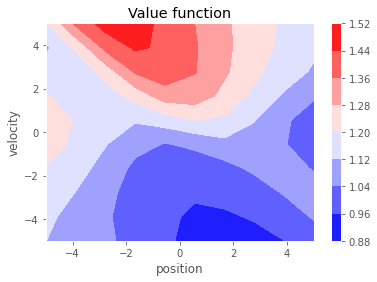

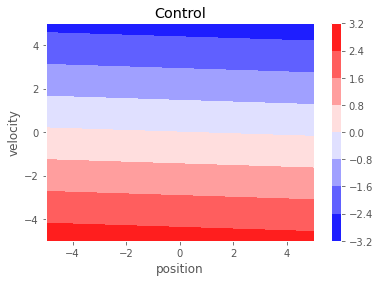

In [5]:
from matplotlib import cm
n=10
x = np.linspace(-5,5,n)
y = np.linspace(-5,5,n)
xv, yv = np.meshgrid(x,y)
zv = np.zeros((n, n))
zu = np.zeros((n, n))
zq = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        v_val = SAC.SVF.predict(jnp.array([xv[i,j], yv[i,j]]))
        _, u_val = SAC.get_control(jnp.array([xv[i,j], yv[i,j]]))
        q_val = SAC.SQF.predict(jnp.array([xv[i,j], yv[i,j]]), 0)
        zv[i,j] = v_val
        zu[i,j] = u_val
        zq[i,j] = q_val

plt.contourf(xv, yv, zq, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('Q-function')
plt.show()

plt.contourf(xv, yv, zv, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('Value function')
plt.show()

plt.contourf(xv, yv, zu, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('Control')
plt.show()

